In [29]:
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os

# load data X

In [30]:
wav_dir = 'train/train/'
files = os.listdir(wav_dir)
X = torch.FloatTensor([])
for f in tqdm(files):
    try:
        # 讀取聲音訊號
        waveform, sample_rate = torchaudio.load(wav_dir+f)
        # 頻譜圖
        specgram = torchaudio.transforms.MelSpectrogram()(waveform)
        #specgram = torchaudio.transforms.Spectrogram()(waveform)
        specgram = torch.unsqueeze(specgram, 0)
        # 加入X
        X = torch.cat([X,specgram],dim=0)
    except:
        print(f,'這筆wav檔案有問題')
        pass
print(X.shape)

train_01046.wav 這筆wav檔案有問題

torch.Size([1199, 1, 128, 201])


# load data Y

In [31]:
Y = pd.read_csv('train\meta_train.csv',index_col='Filename')
Y = Y[Y.index != 'train_01046']
print(Y.shape)
Y.head()

(1199, 2)


,Label,Remark
Filename,,
train_00001,0,Barking
train_00002,0,Barking
train_00003,0,Barking
train_00004,0,Barking
train_00005,0,Barking


In [32]:
Y.Label.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y[['Label']])
Y_one_hot = enc.transform(Y[['Label']]).toarray()
print(Y_one_hot.shape)
Y_one_hot

(1199, 6)


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

# look some sample

['Barking' 'Howling' 'Crying' 'COSmoke' 'GlassBreaking' 'Other' 'Vacuum'
 'Blender' 'Electrics' 'Cat' 'Dishes'] 11


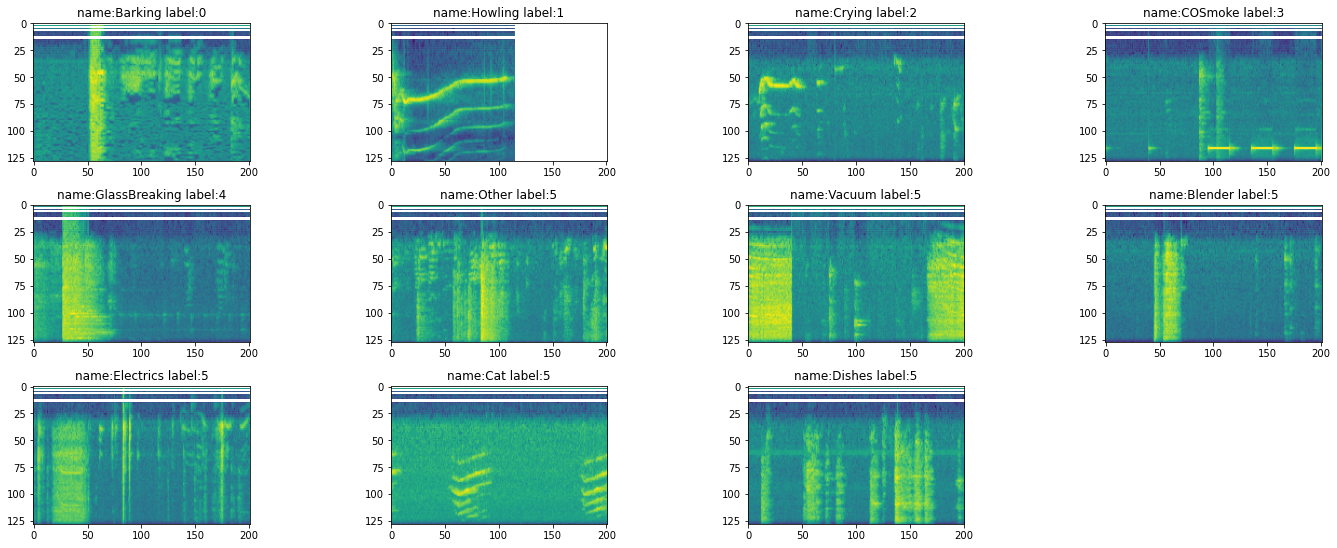

In [35]:
print(Y.Remark.unique(),len(Y.Remark.unique()))
plt.figure(figsize=(20,10))
for j,i in enumerate(Y.Remark.unique()):
    sample = Y[Y.Remark==i].sample(1)
    idx = sample.index[0]
    label = sample['Label'][0]
    idx = int(idx.split('_')[1])
    plt.subplot(4,4,j+1)
    plt.imshow(X[idx,0,:,:].log2())
    title = 'name:{} label:{}'.format(i,label)
    plt.title(title)
plt.tight_layout()
plt.show()

# create pytorch dataset

In [36]:
from torch.utils.data import TensorDataset,DataLoader
import numpy as np

total_data_len = X.shape[0]
train_percent = 0.8
train_size = int(train_percent*total_data_len)
train_idx = list(np.random.choice([*range(total_data_len)],size=train_size,replace=False))
vaild_idx = list(set([*range(total_data_len)]) - set(train_idx))
trainset = TensorDataset(torch.FloatTensor(X)[train_idx],torch.FloatTensor(Y_one_hot)[train_idx])
vaildset = TensorDataset(torch.FloatTensor(X)[vaild_idx],torch.FloatTensor(Y_one_hot)[vaild_idx])
train_iter = DataLoader(trainset,batch_size=64)
vaild_iter = DataLoader(vaildset,batch_size=64)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')